<a href="https://colab.research.google.com/github/AI4Finance-Foundation/FinRL/blob/master/Stock_NeurIPS2018.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Reinforcement Learning for Stock Trading from Scratch: Multiple Stock Trading

* **Pytorch Version** 



<a id='0'></a>
# Part 1. Task Discription

We train a DRL agent for stock trading. This task is modeled as a Markov Decision Process (MDP), and the objective function is maximizing (expected) cumulative return.

We specify the state-action-reward as follows:

* **State s**: The state space represents an agent's perception of the market environment. Just like a human trader analyzing various information, here our agent passively observes many features and learns by interacting with the market environment (usually by replaying historical data).

* **Action a**: The action space includes allowed actions that an agent can take at each state. For example, a ∈ {−1, 0, 1}, where −1, 0, 1 represent
selling, holding, and buying. When an action operates multiple shares, a ∈{−k, ..., −1, 0, 1, ..., k}, e.g.. "Buy
10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or −10, respectively

* **Reward function r(s, a, s′)**: Reward is an incentive for an agent to learn a better policy. For example, it can be the change of the portfolio value when taking a at state s and arriving at new state s',  i.e., r(s, a, s′) = v′ − v, where v′ and v represent the portfolio values at state s′ and s, respectively


**Market environment**: 30 consituent stocks of Dow Jones Industrial Average (DJIA) index. Accessed at the starting date of the testing period.


The data for this case study is obtained from Yahoo Finance API. The data contains Open-High-Low-Close price and volume.


<a id='1'></a>
# Part 2. Install Python Packages

<a id='1.1'></a>
## 2.1. Install packages


In [1]:
## install packages
%pip install wrds
%pip install swig

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!git clone https://github.com/Hakiiiim/FinRL.git

fatal: destination path 'FinRL' already exists and is not an empty directory.


In [3]:
!sudo apt-get update && sudo apt-get install cmake libopenmpi-dev python3-dev zlib1g-dev libgl1-mesa-glx swig

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ InRelease
Hit:2 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal InRelease
Hit:3 http://security.ubuntu.com/ubuntu focal-security InRelease
Hit:4 http://archive.ubuntu.com/ubuntu focal InRelease
Hit:5 http://archive.ubuntu.com/ubuntu focal-updates InRelease
Hit:6 http://ppa.launchpad.net/cran/libgit2/ubuntu focal InRelease
Hit:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease
Hit:8 http://archive.ubuntu.com/ubuntu focal-backports InRelease
Hit:9 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal InRelease
Hit:10 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu focal InRelease
Hit:11 http://ppa.launchpad.net/ubuntugis/ppa/ubuntu focal InRelease
Reading package lists... Done
Reading package lists... Done
Building dependency tree       
Reading state information... Done
python3-dev is already the newest version (3.8.2-0ubuntu2).
libopenmpi-dev is already the newest versio

In [4]:
%pip install setuptools==65.5.0
%pip install -r FinRL/requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
%pip install FinRL/.

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing ./FinRL
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning https://github.com/quantopian/pyfolio.git to /tmp/pip-install-1uce690p/pyfolio_8bec8ad54daa4dceba61d297d432651b
  Running command git clone --filter=blob:none --quiet https://github.com/quantopian/pyfolio.git /tmp/pip-install-1uce690p/pyfolio_8bec8ad54daa4dceba61d297d432651b
  Resolved https://github.com/quantopian/pyfolio.git to commit 4b901f6d73aa02ceb6d04b7d83502e5c6f2e81aa
  Preparing metadata (setup.py) ... done
  Cloning https://github.com/AI4Finance-Foundation/ElegantRL.git to /tmp/pip-install-1uce690p/elegantrl_088625037cab4888b5246badfbd6b187
  Running command git clone --filter=blob:none --quiet https://github.com/AI4Finance-Foundation/ElegantRL.git /tmp/pip-install-1uce690p/elegantrl_088625037cab4888b5246badfbd6b187


In [6]:
%pip install gymnasium

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


<a id='1.3'></a>
## 2.3. Import Packages

In [7]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv

from finrl.meta.data_processor import DataProcessor

from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline
from pprint import pprint

import sys
sys.path.append("../FinRL")

import itertools
import random
import json

/usr/local/lib/python3.9/dist-packages/pyfolio/pos.py:26: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  warnings.warn(


In [8]:
import warnings
warnings.filterwarnings("ignore")

<a id='1.4'></a>
## 2.4. Create Folders

In [9]:
from finrl import config
from finrl import config_tickers
import os
from finrl.main import check_and_make_directories
from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
    TRADE_START_DATE,
    TRADE_END_DATE,
)
print(f"DATA_SAVE_DIR: {DATA_SAVE_DIR}")
check_and_make_directories([DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])



DATA_SAVE_DIR: datasets


<a id='2'></a>
# Part 3. Download Data
Yahoo Finance provides stock data, financial news, financial reports, etc. Yahoo Finance is free.
* FinRL uses a class **YahooDownloader** in FinRL-Meta to fetch data via Yahoo Finance API
* Call Limit: Using the Public API (without authentication), you are limited to 2,000 requests per hour per IP (or up to a total of 48,000 requests a day).



-----
class YahooDownloader:
    Retrieving daily stock data from
    Yahoo Finance API

    Attributes
    ----------
        start_date : str
            start date of the data (modified from config.py)
        end_date : str
            end date of the data (modified from config.py)
        ticker_list : list
            a list of stock tickers (modified from config.py)

    Methods
    -------
    fetch_data()


In [10]:
# from config.py, TRAIN_START_DATE is a string
print(f"TRAIN_START_DATE: {TRAIN_START_DATE}")
# from config.py, TRAIN_END_DATE is a string
print(f"TRAIN_END_DATE: {TRAIN_END_DATE}")

TRAIN_START_DATE: 2014-01-06
TRAIN_END_DATE: 2020-07-31


In [11]:
TRAIN_START_DATE = '2009-01-01'
TRAIN_END_DATE = '2020-07-01'
TRADE_START_DATE = '2020-07-01'
TRADE_END_DATE = '2021-10-31'

In [12]:
if os.path.exists("extra/yahoo_data.csv"):
    df = pd.read_csv("extra/yahoo_data.csv", index_col=0)
else:
    df = YahooDownloader(
        start_date = TRAIN_START_DATE,
        end_date = TRADE_END_DATE,
        ticker_list = config_tickers.DOW_30_TICKER
    ).fetch_data()
    if not os.path.exists("extra"):
        os.makedirs("extra")
    df.to_csv("extra/yahoo_data.csv")

In [13]:
print(config_tickers.DOW_30_TICKER)

['AXP', 'AMGN', 'AAPL', 'BA', 'CAT', 'CSCO', 'CVX', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'KO', 'JPM', 'MCD', 'MMM', 'MRK', 'MSFT', 'NKE', 'PG', 'TRV', 'UNH', 'CRM', 'VZ', 'V', 'WBA', 'WMT', 'DIS', 'DOW']


In [14]:
df.sort_values(['date','tic'],ignore_index=True).head()

,date,open,high,low,close,volume,tic,day
0,2009-01-02,3.067143,3.251429,3.041429,2.758535,746015200,AAPL,4
1,2009-01-02,58.590000,59.080002,57.750000,43.832630,6547900,AMGN,4
2,2009-01-02,18.570000,19.520000,18.400000,15.365307,10955700,AXP,4
3,2009-01-02,42.799999,45.560001,42.779999,33.941101,7010200,BA,4
4,2009-01-02,44.910000,46.980000,44.709999,31.579336,7117200,CAT,4


# Part 4: Preprocess Data
We need to check for missing data and do feature engineering to convert the data point into a state.
* **Adding technical indicators**. In practical trading, various information needs to be taken into account, such as historical prices, current holding shares, technical indicators, etc. Here, we demonstrate two trend-following technical indicators: MACD and RSI.
* **Adding turbulence index**. Risk-aversion reflects whether an investor prefers to protect the capital. It also influences one's trading strategy when facing different market volatility level. To control the risk in a worst-case scenario, such as financial crisis of 2007–2008, FinRL employs the turbulence index that measures extreme fluctuation of asset price.

In [15]:
fe = FeatureEngineer(
    use_technical_indicator=True,
    tech_indicator_list = INDICATORS,
    use_vix=True,
    use_turbulence=True,
    user_defined_feature = False
)
processed = fe.preprocess_data(df)

Successfully added technical indicators
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (3229, 8)
Successfully added vix
Successfully added turbulence index


In [16]:
list_ticker = processed["tic"].unique().tolist()
list_date = list(pd.date_range(processed['date'].min(),processed['date'].max()).astype(str))
combination = list(itertools.product(list_date,list_ticker))

processed_full = pd.DataFrame(combination,columns=["date","tic"]).merge(processed,on=["date","tic"],how="left")
processed_full = processed_full[processed_full['date'].isin(processed['date'])]
processed_full = processed_full.sort_values(['date','tic'])

processed_full = processed_full.fillna(0)

In [17]:
processed_full.sort_values(['date','tic'],ignore_index=True).head(10)

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2009-01-02,AAPL,3.067143,3.251429,3.041429,2.758535,746015200.0,4.0,0.0,2.98139,2.652101,100.0,66.666667,100.0,2.758535,2.758535,39.189999,0.0
1,2009-01-02,AMGN,58.590000,59.080002,57.750000,43.832630,6547900.0,4.0,0.0,2.98139,2.652101,100.0,66.666667,100.0,43.832630,43.832630,39.189999,0.0
2,2009-01-02,AXP,18.570000,19.520000,18.400000,15.365307,10955700.0,4.0,0.0,2.98139,2.652101,100.0,66.666667,100.0,15.365307,15.365307,39.189999,0.0
3,2009-01-02,BA,42.799999,45.560001,42.779999,33.941101,7010200.0,4.0,0.0,2.98139,2.652101,100.0,66.666667,100.0,33.941101,33.941101,39.189999,0.0
4,2009-01-02,CAT,44.910000,46.980000,44.709999,31.579336,7117200.0,4.0,0.0,2.98139,2.652101,100.0,66.666667,100.0,31.579336,31.579336,39.189999,0.0
5,2009-01-02,CRM,8.025000,8.550000,7.912500,8.505000,4069200.0,4.0,0.0,2.98139,2.652101,100.0,66.666667,100.0,8.505000,8.505000,39.189999,0.0
6,2009-01-02,CSCO,16.410000,17.000000,16.250000,11.948335,40980600.0,4.0,0.0,2.98139,2.652101,100.0,66.666667,100.0,11.948335,11.948335,39.189999,0.0
7,2009-01-02,CVX,74.230003,77.300003,73.580002,43.677193,13695900.0,4.0,0.0,2.98139,2.652101,100.0,66.666667,100.0,43.677193,43.677193,39.189999,0.0
8,2009-01-02,DIS,22.760000,24.030001,22.500000,20.597496,9796600.0,4.0,0.0,2.98139,2.652101,100.0,66.666667,100.0,20.597496,20.597496,39.189999,0.0
9,2009-01-02,GS,84.019997,87.620003,82.190002,69.251770,14088500.0,4.0,0.0,2.98139,2.652101,100.0,66.666667,100.0,69.251770,69.251770,39.189999,0.0


<a id='4'></a>
# Part 5. Build A Market Environment in OpenAI Gym-style
The training process involves observing stock price change, taking an action and reward's calculation. By interacting with the market environment, the agent will eventually derive a trading strategy that may maximize (expected) rewards.

Our market environment, based on OpenAI Gym, simulates stock markets with historical market data.

## Data Split
We split the data into training set and testing set as follows:

Training data period: 2009-01-01 to 2020-07-01

Trading data period: 2020-07-01 to 2021-10-31


In [18]:
train = data_split(processed_full, TRAIN_START_DATE,TRAIN_END_DATE)
trade = data_split(processed_full, TRADE_START_DATE,TRADE_END_DATE)
print(len(train))
print(len(trade))

83897
9744


In [19]:
stock_dimension = len(train.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 29, State Space: 291


In [20]:
buy_cost_list = sell_cost_list = [0.001] * stock_dimension
num_stock_shares = [0] * stock_dimension

env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4
}

# e_train_gym = StockTradingEnv(df = train, **env_kwargs)

## Environment Creator for Training in RLLIB

* In RLLIB, an env creator is a function that take as input an EnvContext object (Dict containing the config), and outputs the envirnoment object instanciated with the parameters from the EnvContext.
* We are gonna wrap the envirnoment class in the EnvCompatibility wrapper fro *gymnasium* to account for the changes in the gym API (considered by ray 2.3.0)
* Finally, we are gonna register the environment to ray so that it would be accessible in the DRL trainers.



In [21]:
import psutil
import ray
ray._private.utils.get_system_memory = lambda: psutil.virtual_memory().total
from ray.tune.registry import register_env

from gymnasium.wrappers import EnvCompatibility

In [22]:
def env_creator(env_config):
    # env_config is passed as {} and defaults are set here
    df = env_config.get('df', train)
    hmax = env_config.get('hmax', 100)
    initial_amount = env_config.get('initial_amount', 1000000)
    num_stock_shares = env_config.get('num_stock_shares', [0] * stock_dimension)
    buy_cost_pct = env_config.get('buy_cost_pct', buy_cost_list)
    sell_cost_pct = env_config.get('sell_cost_pct', sell_cost_list)
    state_space = env_config.get('state_space', 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension)
    stock_dim = env_config.get('stock_dim', stock_dimension)
    tech_indicator_list = env_config.get('tech_indicator_list', INDICATORS)
    action_space = env_config.get('action_space', stock_dimension)
    reward_scaling = env_config.get('reward_scaling', 1e-4)

    return EnvCompatibility(StockTradingEnv(
        df=df,
        hmax=hmax,
        initial_amount=initial_amount,
        num_stock_shares=num_stock_shares,
        buy_cost_pct=buy_cost_pct,
        sell_cost_pct=sell_cost_pct,
        state_space=state_space,
        stock_dim=stock_dim,
        tech_indicator_list=tech_indicator_list,
        action_space=action_space,
        reward_scaling=reward_scaling
    ))

<a id='5'></a>
# Part 6: Train RLLIB DRL Agents
* We will initialize a ray instance specifying the resources we put at its disposal
* We will then initialize the config object from the respective default configuration of the algorithm we are going to use. We can then add environment specific parameters, and parallelization specific parameters.
* Finally, we instanciate the trainer and launch the training loop

In [23]:
from ray.rllib.agents import ppo

* Set this to True if you want to run DDPPO instead of PPO

In [24]:
use_ddppo = True

### Init ray (no need to, ray will automatically restart)

In [25]:
ray.shutdown()
print(f"ray is being initialized")
# ray.init(_temp_dir="FinRL/RLLIB/results", num_cpus=1, num_gpus=0)
# ray.init()

ray is being initialized


### Define Config

In [26]:
def pretty(d, indent=1):
    for key, value in d.items():
        print('\t' * indent + str(key) + ':')
        if isinstance(value, dict):
            pretty(value, indent+1)
        else:
            print('\t' * (indent+1) + str(value))

In [27]:
if use_ddppo:
    config = ppo.DDPPOConfig()
else:
    config = ppo.PPOConfig()

# Here set envirnonment parameters if different from default
config = config.environment(
    env_config={'hmax':100, 'initial_amount':1000000}
)

# Training
config = config.training()

# Resources
config = config.resources(
    num_gpus=0,
    num_cpus_per_worker=1,
    num_gpus_per_worker=0,
    num_trainer_workers=2,
    num_gpus_per_trainer_worker = 0,
    num_cpus_per_trainer_worker = 1,
)
# Framework
config = config.framework(
    framework="torch",
)
# Rollouts
config = config.rollouts(
    num_rollout_workers=2,
    num_envs_per_worker=1,
)

print(config)
# pretty(config.to_dict())

### Instanciate trainer

In [28]:
ray.shutdown()
# registering the environment to ray
register_env("finrl", env_creator)
if use_ddppo:
    trainer = ppo.DDPPOTrainer(env='finrl', config=config)
else:
    trainer = ppo.PPOTrainer(env='finrl', config=config)

2023-03-27 10:57:39,424	WARNING deprecation.py:50 -- DeprecationWarning: `algo = Algorithm(env='finrl', ...)` has been deprecated. Use `algo = AlgorithmConfig().environment('finrl').build()` instead. This will raise an error in the future!
2023-03-27 10:57:43,094	INFO worker.py:1544 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 
(pid=15406) /usr/local/lib/python3.9/dist-packages/flax/core/frozen_dict.py:169: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
(pid=15406)   jax.tree_util.register_keypaths(
(pid=15413) /usr/local/lib/python3.9/dist-packages/flax/core/frozen_dict.py:169: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
(pid=15413)   jax.tree_util.register_keypaths(
(RolloutWorker pid=15406) /usr/local/lib/python3.9/dist-packages/gymnasium/wrappers

### Training loop

In [29]:
from tqdm.notebook import tqdm

In [30]:
# (4) Train away -------------------------------------------------------------
total_episodes=20
ep = 0
results = []
bar = tqdm(total=total_episodes, desc="Episodes")
while ep <= total_episodes:
    results.append(trainer.train())
    ep += 1
    bar.update(n=1)
bar.close()

Episodes:   0%|          | 0/20 [00:00<?, ?it/s]

(RolloutWorker pid=15413) /usr/local/lib/python3.9/dist-packages/torch/distributed/distributed_c10d.py:1577: UserWarning: torch.distributed.all_reduce_coalesced will be deprecated. If you must use it, please revisit our documentation later at https://pytorch.org/docs/master/distributed.html#collective-functions
(RolloutWorker pid=15413)   warnings.warn(
(RolloutWorker pid=15406) 2023-03-27 10:58:24,010	WARNING deprecation.py:50 -- DeprecationWarning: `_get_slice_indices` has been deprecated. This will raise an error in the future!
(RolloutWorker pid=15406) /usr/local/lib/python3.9/dist-packages/torch/distributed/distributed_c10d.py:1577: UserWarning: torch.distributed.all_reduce_coalesced will be deprecated. If you must use it, please revisit our documentation later at https://pytorch.org/docs/master/distributed.html#collective-functions
(RolloutWorker pid=15406)   warnings.warn(
(RolloutWorker pid=15413) /usr/local/lib/python3.9/dist-packages/torch/distributed/distributed_c10d.py:1577

In [31]:
# save the trained agent
agent_name = 'ppo'
if use_ddppo:
    agent_name = 'ddppo'
cwd_checkpoint = "FinRL/RLLIB/results/checkpoints/" + str(agent_name) + '_' + str(ep)
trainer.save(cwd_checkpoint)

'FinRL/RLLIB/results/checkpoints/ddppo_21/checkpoint_000021'

## In-sample Performance

Assume that the initial capital is $1,000,000.

### Set turbulence threshold
Set the turbulence threshold to be greater than the maximum of insample turbulence data. If current turbulence index is greater than the threshold, then we assume that the current market is volatile

In [32]:
data_risk_indicator = processed_full[(processed_full.date<TRAIN_END_DATE) & (processed_full.date>=TRAIN_START_DATE)]
insample_risk_indicator = data_risk_indicator.drop_duplicates(subset=['date'])

In [33]:
insample_risk_indicator.vix.describe()

count    2893.000000
mean       18.824245
std         8.489311
min         9.140000
25%        13.330000
50%        16.139999
75%        21.309999
max        82.690002
Name: vix, dtype: float64

In [34]:
insample_risk_indicator.vix.quantile(0.996)

57.40400183105453

In [35]:
insample_risk_indicator.turbulence.describe()

count    2893.000000
mean       34.567956
std        43.790780
min         0.000000
25%        14.962759
50%        24.124228
75%        39.162340
max       652.503974
Name: turbulence, dtype: float64

In [36]:
insample_risk_indicator.turbulence.quantile(0.996)

276.4504974127987

### Trading (Out-of-sample Performance)

We update periodically in order to take full advantage of the data, e.g., retrain quarterly, monthly or weekly. We also tune the parameters along the way, in this notebook we use the in-sample data from 2009-01 to 2020-07 to tune the parameters once, so there is some alpha decay here as the length of trade date extends. 

Numerous hyperparameters – e.g. the learning rate, the total number of samples to train on – influence the learning process and are usually determined by testing some variations.

In [37]:
e_trade_gym = StockTradingEnv(df = trade, turbulence_threshold = 70, risk_indicator_col='vix', **env_kwargs)

## Environment Creator for Trading in RLLIB

* Similarly to the training env, we create an env creator for the trading environment

In [38]:
def env_creator_trading(env_config):
    # env_config is passed as {} and defaults are set here
    df = env_config.get('df', trade)  # changed from the training environment
    
    hmax = env_config.get('hmax', 100)
    initial_amount = env_config.get('initial_amount', 1000000)
    num_stock_shares = env_config.get('num_stock_shares', [0] * stock_dimension)
    buy_cost_pct = env_config.get('buy_cost_pct', buy_cost_list)
    sell_cost_pct = env_config.get('sell_cost_pct', sell_cost_list)
    state_space = env_config.get('state_space', 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension)
    stock_dim = env_config.get('stock_dim', stock_dimension)
    tech_indicator_list = env_config.get('tech_indicator_list', INDICATORS)
    action_space = env_config.get('action_space', stock_dimension)
    reward_scaling = env_config.get('reward_scaling', 1e-4)
    
    # specific for trading
    turbulence_threshold = env_config.get('turbulence_threshold', 70)
    risk_indicator_col = env_config.get('risk_indicator_col', 'vix')

    return EnvCompatibility(StockTradingEnv(
        df=df,
        hmax=hmax,
        initial_amount=initial_amount,
        num_stock_shares=num_stock_shares,
        buy_cost_pct=buy_cost_pct,
        sell_cost_pct=sell_cost_pct,
        state_space=state_space,
        stock_dim=stock_dim,
        tech_indicator_list=tech_indicator_list,
        action_space=action_space,
        reward_scaling=reward_scaling,
        turbulence_threshold=turbulence_threshold,
        risk_indicator_col=risk_indicator_col
    ))

In [39]:
if ray.is_initialized():
    ray.shutdown()
#print(f"ray is being initialized")
#ray.init(_temp_dir="FinRL/RLLIB/results/trading", num_cpus=2, num_gpus=0)

In [42]:
if use_ddppo:
    config = ppo.DDPPOConfig()
else:
    config = ppo.PPOConfig()

# Here set envirnonment parameters if different from default
config = config.environment(
    env_config={'hmax':100, 'initial_amount':1000000}
)

# Training
config = config.training()

# Resources
config = config.resources(
    num_gpus=0,
    num_cpus_per_worker=1,
    num_gpus_per_worker=0,
    num_trainer_workers=2,
    num_gpus_per_trainer_worker = 0,
    num_cpus_per_trainer_worker = 1,
)
# Framework
config = config.framework(
    framework="torch",
)
# Rollouts
config = config.rollouts(
    num_rollout_workers=2,
    num_envs_per_worker=1,
)

# Additional because we are evaluating now
config = config.exploration(
    explore=False
)

print(config)
# pretty(config.to_dict())

In [43]:
ray.shutdown()
# registering the environment to ray
register_env("finrl_trading", env_creator_trading)
# define trainer
if use_ddppo:
    trainer = ppo.DDPPOTrainer(env='finrl_trading', config=config)
else:
    trainer = ppo.PPOTrainer(env='finrl_trading', config=config)

2023-03-27 11:03:29,694	WARNING deprecation.py:50 -- DeprecationWarning: `algo = Algorithm(env='finrl_trading', ...)` has been deprecated. Use `algo = AlgorithmConfig().environment('finrl_trading').build()` instead. This will raise an error in the future!
2023-03-27 11:03:32,251	INFO worker.py:1544 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 
(pid=20552) /usr/local/lib/python3.9/dist-packages/flax/core/frozen_dict.py:169: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
(pid=20552)   jax.tree_util.register_keypaths(
(pid=20551) /usr/local/lib/python3.9/dist-packages/flax/core/frozen_dict.py:169: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
(pid=20551)   jax.tree_util.register_keypaths(
(RolloutWorker pid=20552) /usr/local/lib/python3.9/dist-packages/gy

In [44]:
# load saved agent
cwd_checkpoint = f"FinRL/RLLIB/results/checkpoints/ppo_{total_episodes+1}/checkpoint_0000{total_episodes+1}"
if use_ddppo:
    cwd_checkpoint = f"FinRL/RLLIB/results/checkpoints/ddppo_{total_episodes+1}/checkpoint_0000{total_episodes+1}"
print(f"Restoring from checkpoint {total_episodes+1}")
trainer.restore(cwd_checkpoint)

2023-03-27 11:05:34,720	INFO trainable.py:791 -- Restored on 172.28.0.12 from checkpoint: FinRL/RLLIB/results/checkpoints/ddppo_21/checkpoint_000021
2023-03-27 11:05:34,722	INFO trainable.py:800 -- Current state after restoring: {'_iteration': 21, '_timesteps_total': None, '_time_total': 227.843177318573, '_episodes_total': 6}


Restoring from checkpoint 21


In [45]:
def DRL_prediction(model, environment):
    """make a prediction"""
    state = environment.reset()
    for i in range(len(environment.df.index.unique())):
        action = model.compute_single_action(state)
        state, reward, done, _ = environment.step(action)
        if i == (len(environment.df.index.unique()) - 2):
            account_memory = environment.save_asset_memory()
            actions_memory = environment.save_action_memory()
        if done:
            print("hit end!")
            break
    print("Test Finished!")
    return account_memory, actions_memory

In [46]:
df_account_value, df_actions = DRL_prediction(
    model=trainer, 
    environment = e_trade_gym)

hit end!
Test Finished!


In [47]:
df_account_value.tail()

,date,account_value
331,2021-10-22,1.260650e+06
332,2021-10-25,1.262546e+06
333,2021-10-26,1.262794e+06
334,2021-10-27,1.248122e+06
335,2021-10-28,1.252249e+06


In [48]:
df_actions.head()

,AAPL,AMGN,AXP,BA,CAT,CRM,CSCO,CVX,DIS,GS,...,MRK,MSFT,NKE,PG,TRV,UNH,V,VZ,WBA,WMT
date,,,,,,,,,,,,,,,,,,,,,
2020-07-01,18,100,0,0,0,52,0,25,0,100,...,0,51,0,0,57,0,0,91,100,0
2020-07-02,100,100,100,26,0,15,0,-25,0,-85,...,100,75,0,100,4,0,0,54,-100,0
2020-07-06,-82,100,100,100,4,-40,39,66,100,-15,...,33,-100,0,100,7,66,100,100,21,0
2020-07-07,-7,-48,-100,-100,-4,36,9,100,-98,0,...,-100,100,100,15,100,44,-33,75,-21,30
2020-07-08,17,77,-100,-26,100,100,79,35,21,0,...,100,71,-100,-100,100,28,27,-53,63,-30


<a id='6'></a>
# Part 7: Backtesting Results
Backtesting plays a key role in evaluating the performance of a trading strategy. Automated backtesting tool is preferred because it reduces the human error. We usually use the Quantopian pyfolio package to backtest our trading strategies. It is easy to use and consists of various individual plots that provide a comprehensive image of the performance of a trading strategy.

<a id='6.1'></a>
## 7.1 BackTestStats
pass in df_account_value, this information is stored in env class


In [49]:
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)
perf_stats_all.to_csv("./"+RESULTS_DIR+"/perf_stats_all_"+now+'.csv')

==============Get Backtest Results===========
Annual return          0.183772
Cumulative returns     0.252249
Annual volatility      0.138697
Sharpe ratio           1.289635
Calmar ratio           1.641012
Stability              0.909069
Max drawdown          -0.111987
Omega ratio            1.243924
Sortino ratio          1.874811
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.116044
Daily value at risk   -0.016764
dtype: float64


In [50]:
#baseline stats
print("==============Get Baseline Stats===========")
baseline_df = get_baseline(
        ticker="^DJI", 
        start = df_account_value.loc[0,'date'],
        end = df_account_value.loc[len(df_account_value)-1,'date'])

stats = backtest_stats(baseline_df, value_col_name = 'close')

==============Get Baseline Stats===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (335, 8)
Annual return          0.273520
Cumulative returns     0.379084
Annual volatility      0.139248
Sharpe ratio           1.811893
Calmar ratio           3.062662
Stability              0.918651
Max drawdown          -0.089308
Omega ratio            1.351851
Sortino ratio          2.684720
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.051856
Daily value at risk   -0.016542
dtype: float64


In [51]:
df_account_value.loc[0,'date']

'2020-07-01'

In [52]:
df_account_value.loc[len(df_account_value)-1,'date']

'2021-10-28'

<a id='6.2'></a>
## 7.2 BackTestPlot

==============Compare to DJIA===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (335, 8)


Start date,2020-07-01
End date,2021-10-28
Total months,16
,Backtest
Annual return,18.377%
Cumulative returns,25.225%
Annual volatility,13.87%
Sharpe ratio,1.29
Calmar ratio,1.64
Stability,0.91
Max drawdown,-11.199%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,11.20,2020-09-02,2020-10-28,2020-12-11,73
1,5.47,2021-08-11,2021-09-21,NaT,NaN
2,4.60,2021-05-10,2021-06-18,2021-07-12,46
3,3.66,2021-01-20,2021-01-29,2021-02-08,14
4,3.05,2021-02-17,2021-03-04,2021-03-10,16


Stress Events,mean,min,max
New Normal,0.07%,-3.37%,3.11%


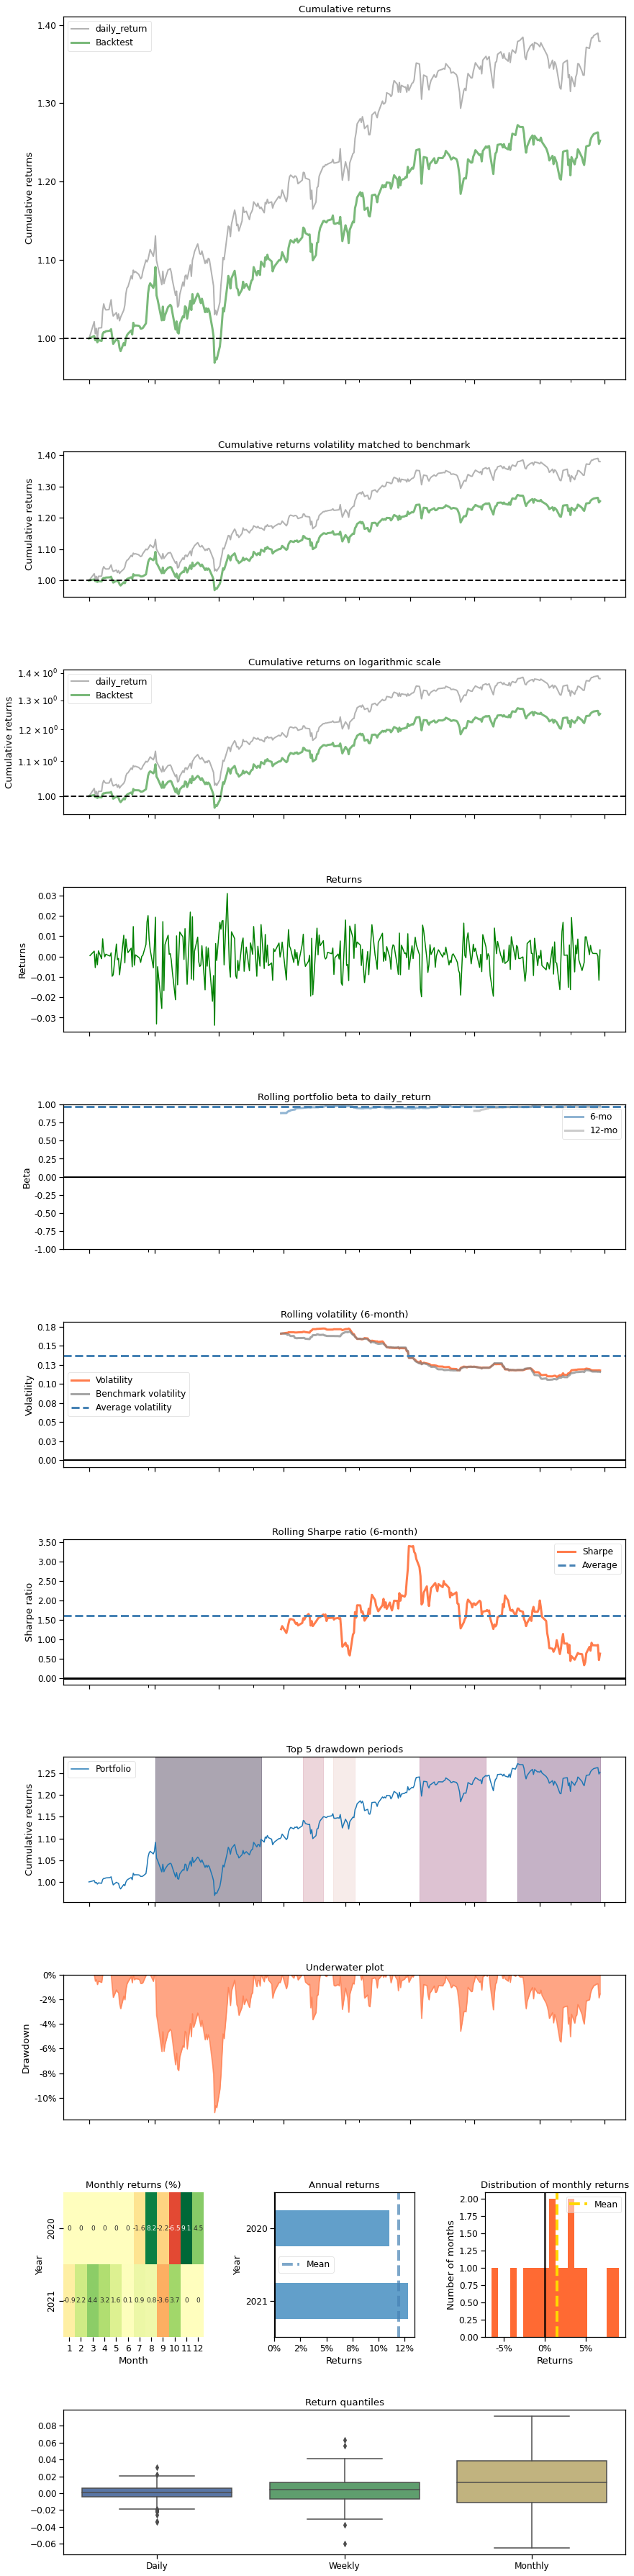

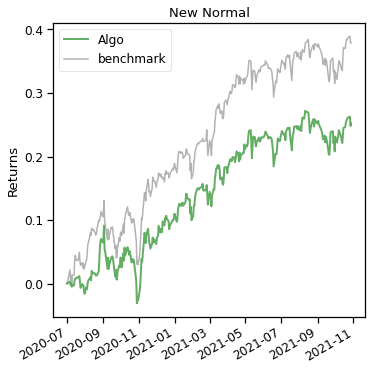

In [53]:
print("==============Compare to DJIA===========")
%matplotlib inline
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX
backtest_plot(df_account_value, 
             baseline_ticker = '^DJI', 
             baseline_start = df_account_value.loc[0,'date'],
             baseline_end = df_account_value.loc[len(df_account_value)-1,'date'])